<a href="https://colab.research.google.com/github/odartsi/AnomalyDetection/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Another Brain - unsupervised anomaly detection
---
## Description:

We want to perform **unsupervised anomaly detection on MNIST digit**.
During training some digit classes (i.e. the anomalous one) are held out.
The model computes a score of normality (the higher the more normal).

**At test time the model computes a score for all digit categories.** 
The performance of the model is evaluated with the ROC AUC. 

A simple model training and evaluation is provided.

The objective is to implement a better model. The model is trained and evaluated 10 times.
For each round a new digit class is chosen to be the anomalous one.
Ano **bold text**
An average AUC (over the 10 digits) of **0.8** is reachable.

The demonstration model is not a neural net trained with gradient descent
but you are not restricted to any kind of solution.

Make sure your solution can be evaluated. 

---
---

## Steps to follow:

[x] Load the dataset

[x] Have a loop where each time the dataset will be split accordingly, by selecting each time a new digit for abnormal

[x] Visualise the training and testing dataset

[x] Create the model (autoencoder in this case)

[x] Evaluate the model






# Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import layers, losses
from keras import metrics

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Load dataset and constract train and test sets

In [3]:
def minst_dataset():
  (x_train, y_train), (x_test, y_test) =  tf.keras.datasets.mnist.load_data()
  x_train = x_train.astype('float32') / 255. 
  x_test = x_test.astype('float32') / 255.
  x_train, y_train = train_set_cleanup(i, x_train, y_train)
  x_test, y_test = test_set_cleanup(i, x_test, y_test)
  return (x_train, y_train), (x_test, y_test)

def train_set_cleanup(anomaly, x, y):
    idx = (y != anomaly).nonzero()
    y[idx] = np.ones(len(idx))
    return (x[idx], y[idx])

def test_set_cleanup(anomaly,x,y):
    y = np.array([1 if y[i] != anomaly else 0 for i in range(len(y))])
    return (x,y)

# Visualisation of the data 


Training dataset

In [38]:
i=9
(x_train, y_train), (x_test, y_test) = minst_dataset()

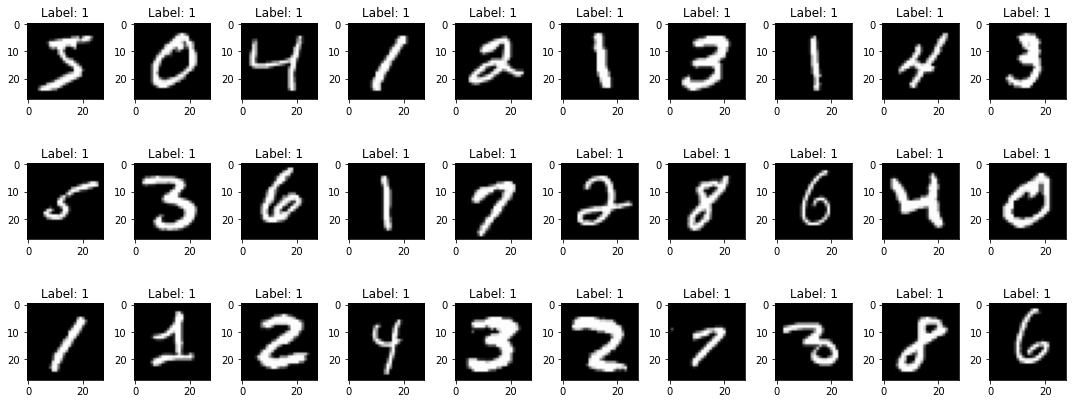

In [28]:
rows = 3
cols = 10
num=30
# plot images
fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols,2*rows))
for i in range(num):
    ax = axes[i//cols, i%cols]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

Testing dataset

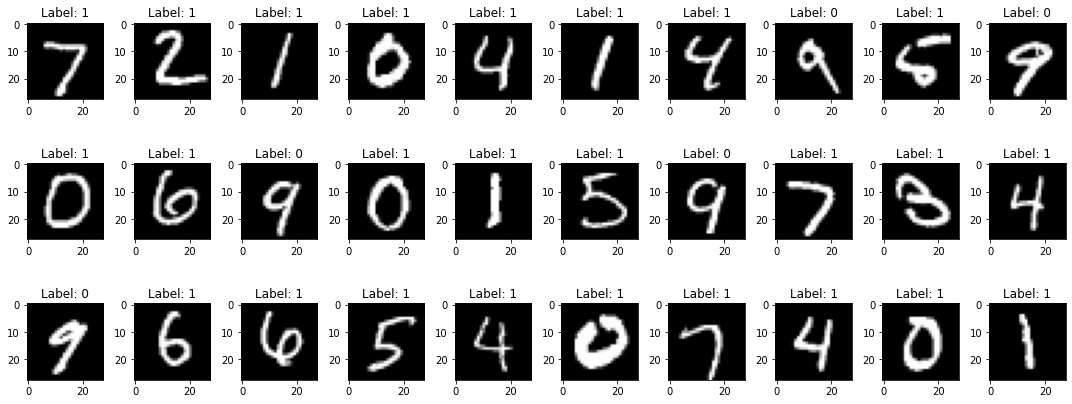

In [29]:
rows = 3
cols = 10
num=30
# plot images
fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols,2*rows))
for i in range(num):
    ax = axes[i//cols, i%cols]
    ax.imshow(x_test[i], cmap='gray')
    ax.set_title('Label: {}'.format(y_test[i]))
plt.tight_layout()
plt.show()

# Autoencoder -- Visualisation

Visualisation of how the autoencoder reconstruct the input images

In [46]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test))

Training dataset

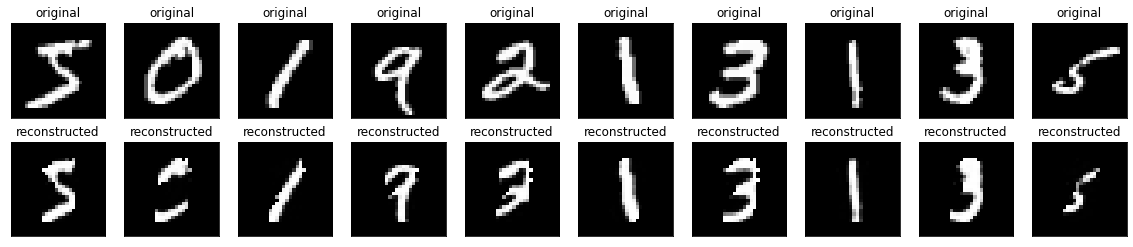

In [48]:
encoded_imgs = autoencoder.encoder(x_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Testing dataset

In [49]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

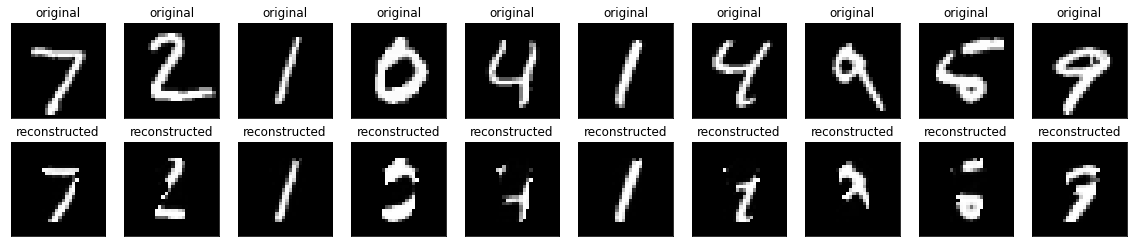

In [50]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Anomaly detection

For the unsupervised anomaly detection by using autoencoders.

During **autoencoding** the impute image data are being compressed and then being reconstructed. The idea is that we compress the train data in a certain way so that when we decompress them, **the error will be relatively low**. Like this the training input image will ideally look very similar to the output reconstructed image.

Like this, once the model will encount a new digit in the test dataset, that haven't seen in the train dataset, we expect that the reconstructed image will have higher loss compare to the train-with no anomalies- data.



The compression and decompression functions are implemented with neural networks, as represented in the image below:
Screenshot 2022-09-22 at 20.27.28.png

In [6]:
aucs=[]
latent_dim=28
for i in range(10):
  (x_train, y_train), (x_test, y_test) = minst_dataset()

  class AnomalyDetector(Model):
    def __init__(self):
      super(AnomalyDetector, self).__init__()
      self.latent_dim = latent_dim 

      self.encoder = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu'),
      ])

      self.decoder = tf.keras.Sequential([
        layers.Dense(784, activation='sigmoid'),
        layers.Reshape((latent_dim, latent_dim))
      ])

   
    def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

  autoencoder = AnomalyDetector()
  autoencoder.compile(optimizer='adam', loss='mae')
  history = autoencoder.fit(x_train, x_train, 
          epochs=5, 
          batch_size=512,
          verbose = 0,
          validation_data=(x_test,x_test),
          shuffle=True)
  
  def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

  def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
  
  # define a loss threshold that below this a digit will be consider as abnormal
  threshold = round(history.history['val_loss'][4],1) 

  # predictions based on the defined threshold
  preds = predict(autoencoder, x_test, threshold= threshold)

  y_pred=[]
  for i in range(len(preds)):
    # the predictions is a tensor of bools of a shape= (28,)
    # my idea here is that there are in the preds enough False 
    # in order to define it as an abnoarmal digit (visualisation in the block below)
    count_true = tf.where(preds[i][4:24]) 
    if count_true.shape[0] < 10: 
      y_pred.append(0)
    else: 
      y_pred.append(1)
  y_pred=np.array(y_pred)

  # compute rocauc
  roc_auc = roc_auc_score(y_test, y_pred)
  aucs.append(roc_auc)

print("roc_auc per digit:")
print(["{:0.3f} ".format(auc) for auc in aucs])
print("average roc_auc:")
print("{:0.3f}".format(sum(aucs)/len(aucs)))


roc_auc per digit:
['0.714 ', '0.359 ', '0.586 ', '0.627 ', '0.553 ', '0.638 ', '0.674 ', '0.306 ', '0.698 ', '0.429 ']
average roc_auc:
0.558


# Visualisation of the predictions

In [25]:
# predictions of an abnormal digit
preds[9]

<tf.Tensor: shape=(28,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False,  True,  True,
       False,  True,  True,  True,  True, False, False, False,  True,
        True])>

In [26]:
# versus predictions of a normal digit
preds[0]

<tf.Tensor: shape=(28,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True])>

# Conclusion

It is clear that by using the autoencoder with the Dense layer did not reach the desired average roc_auc. 
---
Possible reasons for this are:


*   maybe not correct definition of the threshold that I used
*   as well as my approach to define a prediction as a normal or abnormal
---
Different approaches that can improve the performance are:


*   the use of dual encoder and decoder (encoder -> decoder -> encoder -> decoder)
*   or the use of CNN autoencoder (https://www.tensorflow.org/tutorials/generative/cvae)



